#  Tarea 4<br/>Máquinas de Soporte Vectorial
#### Miguel Videla A.<br/>MA5204 Aprendizaje de Máquinas

In [0]:
import os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.spatial import distance_matrix

#### 1. Data Load

In [2]:
# MNIST Dataset Load
os.makedirs('data', exist_ok=True)
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# Dataset Split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=2/7)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
                                                test_size=0.5)
X_train = X_train[:10000]
y_train = y_train[:10000]

# Dataset standard scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

print('Train Set Shape: {}'.format(X_train_sc.shape[0]))
print('Validation Set Shape: {}'.format(X_val_sc.shape[0]))
print('Test Set Shape: {}'.format(X_test_sc.shape[0]))

Train Set Shape: 10000
Validation Set Shape: 10000
Test Set Shape: 10000


#### 2. Data Visualization

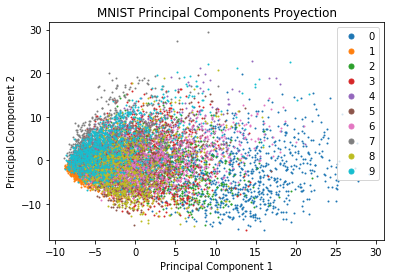

In [3]:
# Principal Components Proyection
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_sc)
# Principal Components Visualization
for label in np.unique(y):
  plt.plot(X_train_pca[y_train == label][:,0], 
           X_train_pca[y_train == label][:,1], 
           '.', ms=2, label=label)
plt.title('MNIST Principal Components Proyection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(markerscale=5)
plt.savefig('00_data_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

#### 3. Kernels Implementation

In [0]:
def gaussian_kernel(x, y, sigma=10):
  return np.exp((-1 * (distance_matrix(x, y) ** 2)) / (2 * sigma ** 2))

def exponential_kernel(x, y, sigma=10):
  return np.exp((-1 * distance_matrix(x, y)) / (2 * sigma ** 2))

def laplacian_kernel(x, y, sigma=10):
  return np.exp((-1 * distance_matrix(x, y)) / (sigma ** 2))

def rational_quadratic_kernel(x, y, c=1):
  return 1 - (distance_matrix(x, y) ** 2 / (distance_matrix(x, y) ** 2 + c))

#### 4. Support Vector Machine

In [0]:
# Principal Components Proyection
pca = PCA(n_components=15)
pca.fit(X_train_sc)
X_train_pc = pca.transform(X_train_sc)
X_val_pc = pca.transform(X_val_sc)
X_test_pc = pca.transform(X_test_sc)
# Kernel RBF
X_train_kernel_rbf = gaussian_kernel(X_train_pc, X_train_pc, sigma=100)
X_val_kernel_rbf = gaussian_kernel(X_val_pc, X_val_pc, sigma=5)
X_test_kernel_rbf = gaussian_kernel(X_test_pc, X_test_pc, sigma=5)

In [6]:
# Model Validation
C_array = np.linspace(0.001, 1, 5)
validation_accuracy_array = []
for C in C_array:
  svc = SVC(C=C, kernel=gaussian_kernel)
  svc.fit(X_train_pc, y_train)
  y_pred_train = svc.predict(X_train_pc)
  y_pred_val = svc.predict(X_val_pc)
  train_accuracy = accuracy_score(y_train, y_pred_train)
  validation_accuracy = accuracy_score(y_val, y_pred_val)
  validation_accuracy_array.append(validation_accuracy)
  print('C: {} | Train Accuracy: {} | Validation Accuracy: {}'.format(C, train_accuracy, validation_accuracy))

C: 0.001 | Train Accuracy: 0.1101 | Validation Accuracy: 0.0992
C: 0.25075 | Train Accuracy: 0.929 | Validation Accuracy: 0.9151
C: 0.5005 | Train Accuracy: 0.9418 | Validation Accuracy: 0.9249
C: 0.75025 | Train Accuracy: 0.949 | Validation Accuracy: 0.9301
C: 1.0 | Train Accuracy: 0.9535 | Validation Accuracy: 0.933


Kernel: Gaussian | C: 1.0 | Validation Accuracy: 0.933
Kernel: Gaussian | C: 1.0 | Test Accuracy: 0.937


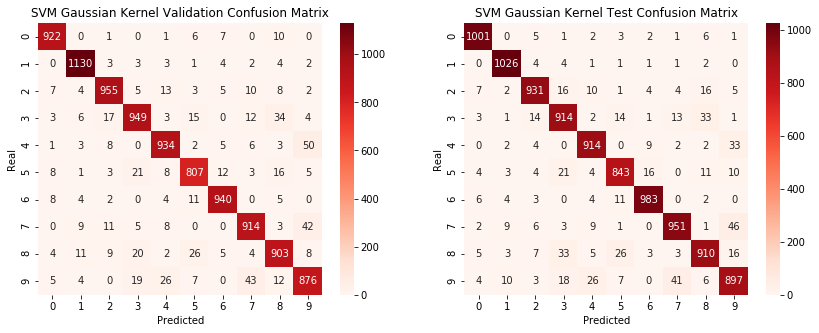

Kernel: Laplacian | C: 1.0 | Validation Accuracy: 0.9067
Kernel: Laplacian | C: 1.0 | Test Accuracy: 0.9127


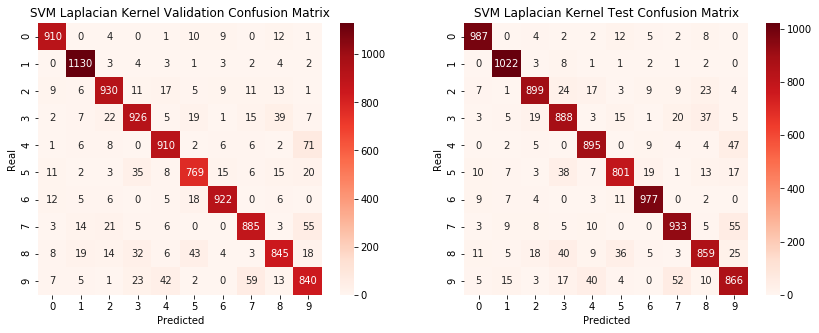

Kernel: Rational Quadratic | C: 1.0 | Validation Accuracy: 0.8784
Kernel: Rational Quadratic | C: 1.0 | Test Accuracy: 0.8865


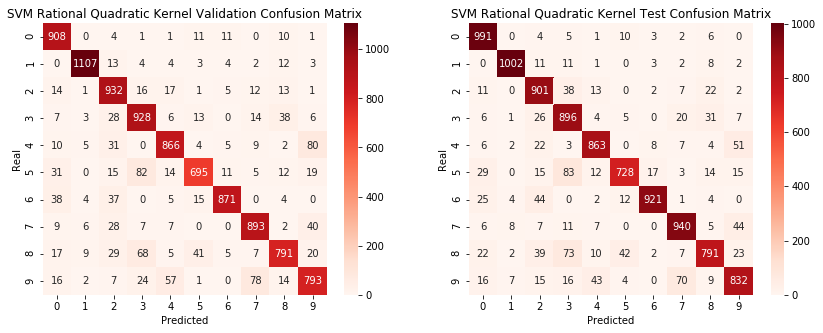

In [7]:
# Kernel Testing
C = C_array[np.argmax(np.array(validation_accuracy_array))]
kernels = [gaussian_kernel, laplacian_kernel, rational_quadratic_kernel]
kernels_names = ['Gaussian', 'Laplacian', 'Rational Quadratic']
data = [[X_val_pc, y_val], [X_test_pc, y_test]]
sets = ['Validation', 'Test']
for i in range(len(kernels)):
  plt.figure(figsize=(14, 5))
  for j in range(len(sets)):
    # Train
    svc = SVC(C=C, kernel=kernels[i])
    svc.fit(X_train_pc, y_train)
    # Prediction
    y_pred = svc.predict(data[j][0])
    test_accuracy = accuracy_score(data[j][1], y_pred)
    print('Kernel: {} | C: {} | {} Accuracy: {}'.format(kernels_names[i], C, sets[j], test_accuracy))
    # Confusion Matrix
    plt.subplot(1, 2, j + 1)
    cm = confusion_matrix(data[j][1], y_pred)
    df_cm = pd.DataFrame(cm, index=np.unique(y), columns=np.unique(y))
    sn.heatmap(df_cm, annot=True, fmt='g', cmap='Reds')
    plt.title('SVM {} Kernel {} Confusion Matrix'.format(kernels_names[i], sets[j]))
    plt.xlabel('Predicted')
    plt.ylabel('Real')
  plt.savefig('0{}_svm_kernel_{}_cm.png'.format(i+1, i+1), dpi=300, bbox_inches='tight')
  plt.show()